In [1]:
import subprocess
import os
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime
from tqdm.notebook import tqdm
import cliffsDelta

# Class Definition (git helper)

In [2]:
class GitCommander:
    SAVE_CURRENT_WORKING_DIRECTORY = 'CURR_DIR=$PWD'
    GO_BACK_TO_WORKING_DIRECTORY = 'cd $CURR_DIR'

    GIT_LOG = "git log --format='%H;%at'"

    def getHead(self):
        return subprocess.check_output(
            f'git rev-parse HEAD',
        shell=True).decode('utf-8')


    def checkout(self, commit):
        checkoutCommand = "git checkout "+commit

        return subprocess.check_output(
            checkoutCommand,
         shell=True).decode('utf-8')


    def gitBlame(self, file, startLine, endLine, commit = None):
        if commit:
            blameCommand = "git blame {} -p {} -L {},{}".format(commit, file, startLine, endLine)
        else:
            blameCommand = "git blame -p {} -L {},{}".format(file, startLine, endLine)

        blameText = subprocess.check_output(
            blameCommand,
        shell=True).decode('utf-8')
        
        if blameText.count('\n') <= 1:
            return None
        else:
            return blameText
        
    def getModifiedLinesFromGitDiff(self, headCommit, commitToCompare):
        diffCommand = "git diff {} {} -U0 | grep -Po '^--- ./\K.*|^@@ -\K[0-9]+(,[0-9]+)?(?= \+[0-9]+(,[0-9]+)? @@)'".format(headCommit, commitToCompare)
        
        diffText = subprocess.check_output(
            diffCommand,
        shell=True).decode('utf-8')
        
        return diffText

    def gitLogInline(self, commit = 'HEAD', author = None):
        if author:
            logCommand = 'git log {} --author="{}" --format="%H;%s;%an;%ct"'.format(commit, author)
        else:
            logCommand = 'git log {} --format="%H;%s;%an;%ct"'.format(commit)
            
        logText = subprocess.check_output(
            logCommand,
            shell=True).decode('latin-1')
        return logText.split('\n')[:-1] # will always have an empty line at the end of the output
    
    def parseGitBlame(self, text):
        returnHash = {}
        splitText = text.split("\n")
        firstLine = splitText[0]
        commitId = firstLine.split(" ")[0]
        secondLine = splitText[1]
        authorName = secondLine.split(" ")[1:]
        fullname = reduce(lambda a, b: a + ' ' + b, authorName)
        return [fullname, commitId]


# Analysis 1: Experience of Type Error Committers

In [22]:
# Assume the working directory is already switched to the required working directory
def process_defect(commit, file, start_line, end_line):
    commander = GitCommander()
    blame = commander.parseGitBlame(commander.gitBlame(file, start_line, end_line, commit))
    blame_author = blame[0]
    blame_commit = blame[1] #use the full commit id
    author_commits = commander.gitLogInline(blame_commit, blame_author)
    
    type_err_commit = author_commits[0].split(';')
    first_commit = author_commits[-1].split(';')
    formatted_time = timeDeltaMonth(int(first_commit[-1]), int(type_err_commit[-1]))
    repo_commits = commander.gitLogInline(blame_commit)
    
    # length -1 to exclude the most recent type error commit
    return [blame_commit, blame_author, len(author_commits) - 1, len(repo_commits) - 1, formatted_time]
    

In [23]:
def timeDeltaMonth(time1, time2):
    time1 = datetime.fromtimestamp(time1)
    time2 = datetime.fromtimestamp(time2)
    delta = relativedelta(time2, time1)
    return delta.years * 12 + delta.months

In [26]:
working_directory = 'C:/Users/chenp/Documents/Mypy-Labelling/'
os.chdir(working_directory)
defects_info = pd.read_csv('defect_authoring.csv')

defects_info['directory'] = defects_info['directory'].apply(lambda li: working_directory + li)
cwd = os.getcwd()

In [27]:
stats = pd.DataFrame([], columns = ['line number', 'filename', 'commit id','issue id', 'buggy commit', 'buggy author', 'author experience', 'project progress', 'timedelta (month)'])
for index, defect in defects_info.iterrows():
    os.chdir(defect['directory'])
    lines = defect['type error lines'].split(', ')
    
    for line in lines:
        row = process_defect(defect['buggy commit'], defect['file path'], line, line)
        row.insert(0, line)
        row.insert(1, defect['file path'])
        row.insert(2, defect['buggy commit'])
        row.insert(3, defect['issue id'])
        stats.loc[0 if pd.isnull(stats.index.max()) else stats.index.max() + 1] = row
    os.chdir(cwd)
stats.to_csv('type.csv')

(array([32.,  7.,  2.,  4.,  0.,  1.,  0.,  0.,  2.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

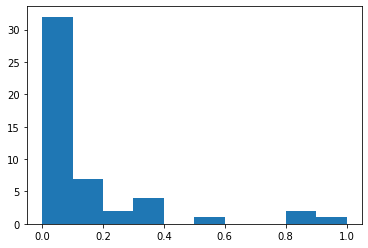

In [7]:
experiences = stats['author experience']
progresses = stats['project progress']
max_exp = max(experiences)
experiences = [i / max_exp for i in experiences]
plt.hist(experiences)

0.01585660117200965


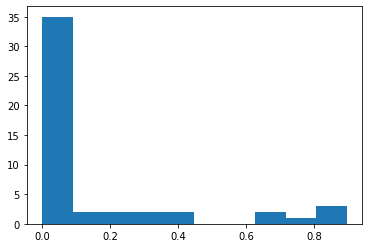

In [9]:
experiences = stats['author experience']
progresses = stats['project progress']
ratios = [experiences[i] / progresses[i] for i in range(len(experiences))]
plt.hist(ratios)
print(ratios[31])

(array([20., 10.,  1.,  5.,  3.,  4.,  2.,  0.,  1.,  3.]),
 array([0.0, 6.9, 13.8, 20.700000000000003, 27.6, 34.5, 41.400000000000006,
        48.300000000000004, 55.2, 62.1, 69.0], dtype=object),
 <a list of 10 Patch objects>)

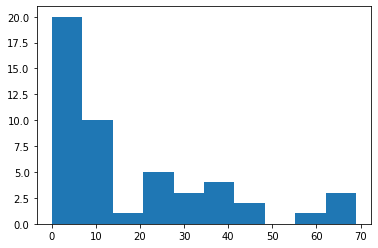

In [10]:
plt.hist(stats['timedelta (month)'])

# Analysis 2: Experience of Non-Type Error Committers

In [28]:
# Assume the working directory is already switched to the required working directory
def analysis_all_modified_lines():
    pass

In [29]:
typeLineSet = set()
for index, info in stats.iterrows():
    typeLineSet.add(info['line number'] + info['filename'] + info['commit id'])

In [83]:
def get_line_changes_for_py_files(lines):
    lineMap = {}
    # go over the commit change to record all the lines change for python files
    i = 0
    lineCount = 0
    while i < len(lines):
        while i < len(lines) and '.py' not in lines[i]:
            i += 1

        if i >= len(lines): break

        filename = lines[i]
        lineMap[filename] = []
        i += 1

        while i < len(lines):
            if lines[i].isdigit():
                lineMap[filename].append(int(lines[i]))
                lineCount += 1
            elif ',' in lines[i]:
                line = lines[i].split(',')
                start = int(line[0])
                count = int(line[1])
                for j in range(0, count):
                    lineMap[filename].append(start + j)
                    lineCount += 1
            else:
                break
            i += 1
    return (lineMap, lineCount)

def get_blame_stats(commit, lineMap, count=0):
    stats = []
    
    if count > 0:
        pBar = tqdm(total = count, leave=False)
    
    for key in lineMap:
        for line in lineMap[key]:
            # ignore type-related lines
            if '{}{}{}'.format(line, key, commit) not in typeLineSet:
                row = process_defect(commit, key, line, line)
                row = [line, key, commit] + row
                stats.append(row)
            if count > 0:
                pBar.update(1)
    
    if count > 0:
        pBar.close()
        
    return stats
            
def process_commit_blame(defect):
    os.chdir(cwd)

    os.chdir(defect['directory'])
    headCommit = defect['buggy commit']
    commitToCompare = defect['fix commit']
    diffCommand = "git diff {} {} -U0 | grep -Po '^--- ./\K.*|^@@ -\K[0-9]+(,[0-9]+)?(?= \+[0-9]+(,[0-9]+)? @@)'".format(headCommit, commitToCompare)
    
    # execute the diff command with grep pattern matching in a spawned child bash shell for windows
    with subprocess.Popen(['sh'],stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE, shell=True) as process:
        output = process.communicate(diffCommand.encode())[0].decode('utf-8')
    
    output = output.split('\n')
    (lineMap, count) = get_line_changes_for_py_files(output)
    authorStats = get_blame_stats(headCommit, lineMap, count)
    
    os.chdir(cwd)
    return authorStats

In [84]:
idSet = set()
nonTypeStats = pd.DataFrame([], columns = ['line number', 'filename', 'commit id', 'buggy commit', 'buggy author', 'author experience', 'project progress', 'timedelta (month)'])

pBar = tqdm(total=defects_info.shape[0], leave=False)
for index, defect in defects_info.iterrows():
    if defect['id'] not in idSet:
        rows = process_commit_blame(defect)
        for row in rows:
            nonTypeStats.loc[0 if pd.isnull(nonTypeStats.index.max()) else nonTypeStats.index.max() + 1] = row
        idSet.add(defect['id'])
    pBar.update(1)
nonTypeStats.to_csv('non_type.csv')

C:\Users\chenp\Documents\Mypy-Labelling\4\ansible


C:\Users\chenp\Documents\Mypy-Labelling\16\nupic


C:\Users\chenp\Documents\Mypy-Labelling\34\MikaLendingBot


C:\Users\chenp\Documents\Mypy-Labelling\35\ansible


C:\Users\chenp\Documents\Mypy-Labelling\38\ansible


C:\Users\chenp\Documents\Mypy-Labelling\42\ansible


C:\Users\chenp\Documents\Mypy-Labelling\44\blaze


C:\Users\chenp\Documents\Mypy-Labelling\47\manticore


C:\Users\chenp\Documents\Mypy-Labelling\50\ansible


C:\Users\chenp\Documents\Mypy-Labelling\56\b2share


C:\Users\chenp\Documents\Mypy-Labelling\61\streamalert


C:\Users\chenp\Documents\Mypy-Labelling\64\ansible


C:\Users\chenp\Documents\Mypy-Labelling\70\pandas


C:\Users\chenp\Documents\Mypy-Labelling\74\ansible


C:\Users\chenp\Documents\Mypy-Labelling\84\docido-python-sdk


C:\Users\chenp\Documents\Mypy-Labelling\87\astropy


C:\Users\chenp\Documents\Mypy-Labelling\88\django-shop
C:\Users\chenp\Documents\Mypy-Labelling\100\LinuxGSM


C:\Users\chenp\Documents\Mypy-Labelling\110\ensime-vim


C:\Users\chenp\Documents\Mypy-Labelling\115\ansible


C:\Users\chenp\Documents\Mypy-Labelling\117\ansible


C:\Users\chenp\Documents\Mypy-Labelling\128\ansible


C:\Users\chenp\Documents\Mypy-Labelling\144\maltrieve
C:\Users\chenp\Documents\Mypy-Labelling\158\astropy


C:\Users\chenp\Documents\Mypy-Labelling\161\ansible


C:\Users\chenp\Documents\Mypy-Labelling\218\ansible


C:\Users\chenp\Documents\Mypy-Labelling\222\ansible


C:\Users\chenp\Documents\Mypy-Labelling\230\terra-terminal


C:\Users\chenp\Documents\Mypy-Labelling\248\streamalert


C:\Users\chenp\Documents\Mypy-Labelling\285\inspire-next


C:\Users\chenp\Documents\Mypy-Labelling\291\incubator-superset


C:\Users\chenp\Documents\Mypy-Labelling\318\ansible


C:\Users\chenp\Documents\Mypy-Labelling\325\SoCo


C:\Users\chenp\Documents\Mypy-Labelling\327\osmaxx


C:\Users\chenp\Documents\Mypy-Labelling\329\eq-survey-runner
C:\Users\chenp\Documents\Mypy-Labelling\363\tribler
C:\Users\chenp\Documents\Mypy-Labelling\387\ansible


C:\Users\chenp\Documents\Mypy-Labelling\391\ansible


C:\Users\chenp\Documents\Mypy-Labelling\397\tribler


In [85]:
stats = pd.read_csv('type.csv')
nonTypeStats = pd.read_csv('non_type.csv')

In [86]:

nonTypeStatsNoDup = nonTypeStats.drop_duplicates(subset='buggy commit', ignore_index=True)
statsNoDup = stats.drop_duplicates(subset='buggy commit', ignore_index=True)

In [87]:
nonTypeStats

,Unnamed: 0,line number,filename,commit id,buggy commit,buggy author,author experience,project progress,timedelta (month)
0,0,30,lib/ansible/module_utils/iosxr.py,ec9582f,eb1453a366403d8f95208517484f632b1da09778,Peter Sprygada,616,28721,43
1,1,69,lib/ansible/module_utils/iosxr.py,ec9582f,7c6916f8d1af7fa6252aee7f7af73a5250c754a8,Peter Sprygada,557,27989,42
2,2,85,lib/ansible/module_utils/iosxr.py,ec9582f,7c6916f8d1af7fa6252aee7f7af73a5250c754a8,Peter Sprygada,557,27989,42
3,3,261,lib/ansible/modules/network/iosxr/iosxr_system.py,ec9582f,4cdb266dac852859f695b0555cbe49e58343e69a,Peter Sprygada,558,28007,42
4,4,263,lib/ansible/modules/network/iosxr/iosxr_system.py,ec9582f,4cdb266dac852859f695b0555cbe49e58343e69a,Peter Sprygada,558,28007,42
...,...,...,...,...,...,...,...,...,...
498,498,252,TriblerGUI/widgets/editchannelpage.py,743adf0,a5bc66e859ee117fa12ff3153176c912c3a6d1c7,Martijn de Vos,610,12291,12
499,499,459,TriblerGUI/widgets/editchannelpage.py,743adf0,a5bc66e859ee117fa12ff3153176c912c3a6d1c7,Martijn de Vos,610,12291,12
500,500,460,TriblerGUI/widgets/editchannelpage.py,743adf0,a5bc66e859ee117fa12ff3153176c912c3a6d1c7,Martijn de Vos,610,12291,12
501,501,461,TriblerGUI/widgets/editchannelpage.py,743adf0,a5bc66e859ee117fa12ff3153176c912c3a6d1c7,Martijn de Vos,610,12291,12


# Ratio Normalizer

In [88]:
def ratio(list1, list2):
    return [list1[i] / list2[i] if list2[i] != 0 else 1 for i in range(len(list1))]


In [89]:
from scipy.stats import mannwhitneyu

typeData = ratio(statsNoDup['author experience'], statsNoDup['project progress'])
nonTypeData = ratio(nonTypeStatsNoDup['author experience'], nonTypeStatsNoDup['project progress'])

stat, p = mannwhitneyu(nonTypeData,typeData)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1515.500, p=0.362


# No Normalization

In [90]:
stat, p = mannwhitneyu(statsNoDup['author experience'],nonTypeStatsNoDup['author experience'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1510.000, p=0.350


# Max Normalization

In [91]:
max_val =  max(statsNoDup['author experience'])
typeData = [a / max_val for a in statsNoDup['author experience']]
max_val = max(nonTypeStatsNoDup['author experience'])
nonTypeData = [a / max_val for a in nonTypeStatsNoDup['author experience']]

stat, p = mannwhitneyu(nonTypeData,typeData)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1567.000, p=0.475


# Cliff Delta Test

## No Normalization

In [92]:
d, res = cliffsDelta.cliffsDelta(statsNoDup['author experience'], nonTypeStatsNoDup['author experience'])
print('res: {}, d: {}'.format(res, d))

res: negligible, d: -0.04339562876148242


In [93]:
max_val =  max(statsNoDup['author experience'])
typeData = [a / max_val for a in statsNoDup['author experience']]
max_val = max(nonTypeStatsNoDup['author experience'])
nonTypeData = [a / max_val for a in nonTypeStatsNoDup['author experience']]
d, res = cliffsDelta.cliffsDelta(typeData, nonTypeData)
print('res: {}, d: {}'.format(res, d))

res: negligible, d: -0.007285397529299968


558